### Note:

The file "aux.py" was changed to "aux_file.py". The notebook also need the Policy and some common libraries to run. seaborn should be version 0.11.0.

# Changes

We did some changes from the last assignement. Firstly, we specified our utility function. We now define utility as the following: For each symptom, if the patient _did_ experience the symptoms before, but not after the treatment, a positive weight is added. If the patient _did not_ experience the symptom before, but did after, there is a negative weight added. The weights are corresponding to the severity of the disease, and they are taken from the code sceleton. Finally, if an action is used, a negative constant is added. This symbolizes that the treatment is not free. This allows us to not treat poeple that are completely healthy before and after. 

Secondly, we drasticly changed our model to a more complex one. We think this model is more like what the assignment-creator thought of, but we are not happy with how complex it is. However, we now predict the outcomes rather than the utility/reward. We start by initializing some actions from the RandomPolicy class. Thereafter, for each of the three treatments, for each of the 9 symptoms ('Covid-Positive', 'No-Taste/Smell', 'Fever', 'Headache', 'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death'), we fit a logistic regression model to predict if the patient will experience the symptom, given an action (treatment) and given the data. The data is the symptom before the treatment, age, income, gender and the comorbidieties. We remove genes because it only looks like noise in all our tests, and we assume that the symptoms does not affect each other. Then, we chose and action for each person corresponding to the highest expected reward for each person. If all the rewards are negative, we chose no treatment. After getting the actions once, the observe() function can be called again, to update the fitting process on the new features, actions and outcomes. 

In [16]:
import numpy as np
import pandas as pd
from aux_file import symptom_names
import simulator
from IPython import embed
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [17]:
class Policy:
    """ A policy for treatment/vaccination. """
    def __init__(self, n_actions, action_set):
        """ Initialise.
        Args:
        n_actions (int): the number of actions
        action_set (list): the set of actions
        """
        self.n_actions = n_actions
        self.action_set = action_set
    
    def initialize_data(self, n_population):
        population = simulator.Population(128, 3, 3)
        treatment_policy = RandomPolicy(3, list(range(3))) 
        self.n_population = n_population
        self.features = population.generate(self.n_population)
        self.actions = treatment_policy.get_action(self.features)
        self.outcomes = population.treat(list(range(n_population)), self.actions)
        return self.features, self.actions, self.outcomes
    
    def feature_select(self, X, symptom_index=1):
        """
        Chooses some columns in X.
        0 Covid-Recovered
        1 Covid-Positive
        2 No-Taste/Smell
        3 Fever
        4 Headache
        5 Pneumonia
        6 Stomach
        7 Myocarditis
        8 Blood-Clots
        9 Death
        10 Age
        11 Gender
        12 Income
        141 Asthma
        142 Obesity
        143 Smoking
        144 Diabetes
        145 Heart disease
        146 Hypertension
        """
        N = X[:, [symptom_index, 10, 11, 12, 141, 142, 143, 144, 143, 144, 145, 146]]
        # df = add_feature_names(X)
        # temp1 = df.iloc[:, :13]
        # temp2 = df.iloc[:, -9:-3]
        # return np.asmatrix(temp1.join(temp2))
        return N
        
    def get_reward(self, features, actions, outcome, penalty=1.5, threshold=0.5):
        """
        Out:
            rewards (np.array): Array of rewards, corresponding to the persons
                in features (and actions and outcome).
        This method calculates the reward, the utility of a single person. This
        is returned as an array with values corresponding to the reward of each 
        persons. 
        The reward is given by a positive weight if a person has recovered 
        a symptom, and the corresponding negativ weight, times a penalty factor
        "penalty" if the person has gotten the symptom. If the person had the
        symptom and did not get rid of it, nothing is done.
        """
        rewards = np.zeros(len(outcome))
        weights = [0, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100.0]
        for t in range(len(features)):
            utility = 0
            for i in range(1, len(weights)): # i loops over the sypmtom indexes
                if features[t, i] == 1 and outcome[t, i-1] < threshold:
                    utility += weights[i]
                if features[t, i] == 0 and outcome[t, i-1] >= threshold:
                    utility -= weights[i] * penalty
            if sum(actions[t, :]) > 0: # Some action were used
                utility = utility - 0.1 # The treatment is not free
            rewards[t] = utility 
            
        return rewards
        
    ## Observe the features, treatments and outcomes of one or more individuals
    def observe(self, features, actions, outcomes):
        """Observe features, actions and outcomes.
        Args:
        features (t*|X| array)
        actions (t*|A| array)
        outcomes (t*|Y| array)
        The function is used to adapt a model to the observed
        outcomes, given the actions and features. I suggest you create
        a model that estimates P(y | x,a) and fit it as appropriate.
        If the model cannot be updated incrementally, you can save all
        observed x,a,y triplets in a database and retrain whenever you
        obtain new data.
        Pseudocode:
            self.data.append(features, actions, outcomes)
            self.model.fit(data)
        """
        self.features = features
        self.actions = actions
        self.outcomes = outcomes
        symtpoms = ['Covid-Recovered', 'Covid-Positive', 'No-Taste/Smell', 'Fever',
                    'Headache', 'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death']
        symptom_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        # symptom_indexes = 9
        models = []
        for treatment in range(3):
            indexes = self.actions[:, treatment] == 1
            for symptom_index in symptom_indexes:
                feat = self.features[indexes]
                out = self.outcomes[indexes]
                x_data = self.feature_select(feat, symptom_index)
                y_data = out[:, symptom_index]
                logistic_model = LogisticRegression()
                scaler = preprocessing.StandardScaler().fit(x_data)
                x_scaled = scaler.transform(x_data)
                model = logistic_model.fit(x_scaled, y_data)
                # print(f"sum y_data: {sum(y_data)}")
                models.append(logistic_model)
        self.models1 = models[:9]
        self.models2 = models[9:18]
        self.models3 = models[18:]
        
    def get_utility(self, features, actions, outcome):
        """ Obtain the empirical utility of the policy on a set of one or more people. 
        If there are t individuals with x features, and the action
        
        Args:
        features (t*|X| array)
        actions (t*|A| array)
        outcomes (t*|Y| array)
        Returns:
        Empirical utility of the policy on this data.
        """
        utility = sum(self.get_reward(features, actions, outcome))
        return utility
        
    def get_action(self, features):
        """Get actions for one or more people. 
        Args: 
        features (t*|X| array)
        Returns: 
        actions (t*|A| array)
        Here you should take the action maximising expected utility
        according to your model. This model can be arbitrary, but
        should be adapted using the observe() method.
        Pseudocode:
           for action in appropriate_action_set:
                p = self.model.get_probabilities(features, action)
                u[action] = self.get_expected_utility(action, p)
           return argmax(u)
        You are expected to create whatever helper functions you need.
        """
        symtpoms = ['Covid-Recovered', 'Covid-Positive', 'No-Taste/Smell', 'Fever',
                    'Headache', 'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death']
        symptom_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        post_symptoms1 = np.zeros((len(features), len(symptom_indexes)))
        post_symptoms2 = np.zeros((len(features), len(symptom_indexes)))
        post_symptoms3 = np.zeros((len(features), len(symptom_indexes)))
        
        for symptom_index in symptom_indexes: 
            x_data = self.feature_select(features, symptom_index)
            scaler = preprocessing.StandardScaler().fit(x_data)
            x_scaled = scaler.transform(x_data)
            pred1 = self.models1[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            pred2 = self.models2[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            pred3 = self.models3[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            post_symptoms1[:, symptom_index-1] = pred1
            post_symptoms2[:, symptom_index-1] = pred2
            post_symptoms3[:, symptom_index-1] = pred3
        
        mock_actions = np.ones((self.n_population, 3)) # Represent an actions has been done
        rewards1 = self.get_reward(features, mock_actions, post_symptoms1)
        rewards2 = self.get_reward(features, mock_actions, post_symptoms2)
        rewards3 = self.get_reward(features, mock_actions, post_symptoms3)
        
        actions = np.zeros([n_population, self.n_actions])
        for t in range(n_population):
            # print(f"1: {pred1[t]} 2: {pred2[t]} 3: {pred3[t]}")
            if np.max(np.asarray([rewards1[t], rewards2[t], rewards3[t]])) < 0:
                actions[t, 0] = 0 # Do nothing
            elif rewards1[t] >= rewards2[t] and rewards1[t] >= rewards3[t]:
                actions[t, 0] = 1
            elif rewards2[t] >= rewards1[t] and rewards2[t] >= rewards3[t]:
                actions[t, 1] = 1
            elif rewards3[t] >= rewards1[t] and rewards3[t] >= rewards2[t]:
                actions[t, 2] = 1
        # embed()
        return actions
    
    def get_arguments(self):
        return self.features, self.actions, self.outcomes

In [18]:
class RandomPolicy(Policy):
    """ This is a purely random policy!"""

    def get_utility(self, features, action, outcome):
        """Here the utiliy is defined in terms of the outcomes obtained only, ignoring both the treatment and the previous condition.
        """
        actions = self.get_action(features)
        utility = 0
        utility -= 0.2 * sum(outcome[:,symptom_names['Covid-Positive']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Taste']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Fever']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Headache']])
        utility -= 0.5 * sum(outcome[:,symptom_names['Pneumonia']])
        utility -= 0.2 * sum(outcome[:,symptom_names['Stomach']])
        utility -= 0.5 * sum(outcome[:,symptom_names['Myocarditis']])
        utility -= 1.0 * sum(outcome[:,symptom_names['Blood-Clots']])
        utility -= 100.0 * sum(outcome[:,symptom_names['Death']])
        return utility
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.
        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.
        Returns:
        A t*|A| array of actions
        """

        n_people = features.shape[0]
        ##print("Acting for ", n_people, "people");
        actions = np.zeros([n_people, self.n_actions])
        for t in range(features.shape[0]):
            action = np.random.choice(self.action_set)
            if (action >= 0):
                actions[t,action] = 1
            
        return actions

In [19]:
def add_feature_names(X):
    features_data = pd.DataFrame(X)
    # features =  ["Covid-Recovered", "Age", "Gender", "Income", "Genome", "Comorbidities", "Vaccination status"]
    features = []
    # features += ["Symptoms" + str(i) for i in range(1, 11)]
    features += ["Covid-Recovered", "Covid-Positive", "No-Taste/Smell", "Fever", 
                 "Headache", "Pneumonia", "Stomach", "Myocarditis", 
                 "Blood-Clots", "Death"]
    features += ["Age", "Gender", "Income"]
    features += ["Genome" + str(i) for i in range(1, 129)]
    # features += ["Comorbidities" + str(i) for i in range(1, 7)]
    features += ["Asthma", "Obesity", "Smoking", "Diabetes", 
                 "Heart disease", "Hypertension"]
    features += ["Vaccination status" + str(i) for i in range(1, 4)]
    features_data.columns = features
    return features_data

Since we changed the model, the privatized data behaves differently, so we will repeat it here. We now think it makes more sence to privatize the actions, despite the privacy risk given in the feedback. This is because privatizing the symptoms can give a false sence of good utility, since it can artificially add symtpoms before treatment, and remove symptoms after treatment, which artificially makes the policy look better. 

In [20]:
def privatize_actions(A, theta):
    """
    Adds noise to the actions chosen bu the model. This is currently done
    a little bit primitive, since person no longer receives exactly one
    treatment.
    """
    A1 = A.copy()
    for i in range(A1.shape[1]):
        A1[:, i] = randomize(A1[:, i], theta)
    return A1
    
def randomize(a, theta):
    """
    Randomize a single column. Simply add a cointoss to "theta" amount of the data
    """
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = np.random.choice([0, 1], size=a.shape)
    response = np.array(a)
    response[~coins] = noise[~coins]
    return response 

In [21]:
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 10000
population = simulator.Population(n_genes, n_vaccines, n_treatments)
np.random.seed(57)
X = population.generate(n_population) # Population
# embed()
treatment_policy = Policy(n_treatments, list(range(n_treatments)))
np.random.seed(57)
features, actions, outcomes = treatment_policy.initialize_data(n_population)
treatment_policy.observe(features, actions, outcomes)
# features, actions, outcomes = treatment_policy.get_arguments()

A = treatment_policy.get_action(X) # Actions 
U = population.treat(list(range(n_population)), A) # Outcome

In [22]:
thetas = [1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
utility_list = np.zeros(len(thetas) + 1)
utility_list[0] = treatment_policy.get_utility(features, A, U)
for i in range(len(thetas)):
    np.random.seed(57)
    A_noise = privatize_actions(A, thetas[i])
    U_noise = population.treat(list(range(n_population)), A_noise)
    utility_list[i+1] = treatment_policy.get_utility(X, A_noise, U_noise)

In [23]:
utility_list

array([2507.15, 1604.15, 1691.4 , 1289.  ,  939.4 ,  989.6 ,  445.65,
        501.2 ,  470.45,  106.95,  -99.65,  153.4 ,  -38.35,  532.  ])

So we see that the utility declines with the added noise. Note that there are a large amount of random fluctuation here, but we there is a definitive negative trend anyhow. 

# Fair Policies

### Note:

This part is done with the old model. This is because we were unhappy with how complex our new model got, and it generally preferes not to give treatment. Therefore, we will look at the old one to see more clear results. 


We would like to investigate the fairness of our decision-making algorithm. When we are deciding the treatment method for each individual in our population, we want to make sure that the decision is made fairly and we are just to the individuals. The sensitive variables in our data set are `Age`, `Income` and `Gender`. We want ensure that the sensitive variables do not affect the treatment given to the individuals, such that $\mathbb{P}^{\pi}_{\theta}(a|z) = \mathbb{P}^{\pi}_{\theta}(a)$ for all actions $a$ and sensitive variables $z$.

For example, if we have more men than women in our population, the decision-making algorithm will be adapted to men.

We will now analyze the population and look at some numbers and graphs. We will start by generating data and preprocessing. We remove the columns corresponding to genes, and we add the action columns which corresponds to the treatment chosen for each individual.

In [24]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import simulator
from policy import Policy, add_feature_names, add_action_names, add_outcome_names

In [25]:
# Generate data
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 10000
population = simulator.Population(n_genes, n_vaccines, n_treatments)
treatment_policy = Policy(n_treatments, list(range(n_treatments)))
X = population.generate(n_population)
X = add_feature_names(X)

Initialising policy with  3 actions
A = { [0, 1, 2] }


In [26]:
# Remove genes
temp1 = X.iloc[:, :13] 
temp2 = X.iloc[:, -9:]
features = temp1.join(temp2)

In [27]:
# Get actions
np.random.seed(57)
A = treatment_policy.get_action(X)
features = pd.DataFrame(X)
actions = pd.DataFrame(A)
actions.columns = ["Treatment1", "Treatment2", "Treatment3"]
features = features.join(actions)

# Create a single Treatment column for easier data visualizing 
features.loc[features.Treatment1 == 1.0, "Treatment"] = "1"
features.loc[features.Treatment2 == 1.0, "Treatment"] = "2"
features.loc[features.Treatment3 == 1.0, "Treatment"] = "3"

Initialising policy with  3 actions
A = { [0, 1, 2] }


## Gender

We will first investigate `Gender`. We assume that `Gender` is `0.0` for men and `1.0` for women.

In [28]:
# Gender
women_nr = features[features.Gender == 1.0].shape[0]
men_nr = features[features.Gender == 0.0].shape[0]
g1 = features.groupby(by="Gender")["Treatment1"].value_counts(normalize=True)
g2 = features.groupby(by="Gender")["Treatment2"].value_counts(normalize=True)
g3 = features.groupby(by="Gender")["Treatment3"].value_counts(normalize=True)

In [29]:
g1, g2, g3 # Vet ikke om det er nødvendig

(Gender  Treatment1
 0.0     0.0           0.842327
         1.0           0.157673
 1.0     0.0           0.707278
         1.0           0.292722
 Name: Treatment1, dtype: float64, Gender  Treatment2
 0.0     0.0           0.671013
         1.0           0.328987
 1.0     0.0           0.706481
         1.0           0.293519
 Name: Treatment2, dtype: float64, Gender  Treatment3
 0.0     1.0           0.513340
         0.0           0.486660
 1.0     0.0           0.586241
         1.0           0.413759
 Name: Treatment3, dtype: float64)

In [30]:
print(f"Number of women: {women_nr}")
print(f"Number of men: {men_nr}")

Number of women: 5015
Number of men: 4985


We almost have equal amount of men and women in our population. We now check which treatment each gender has gotten:

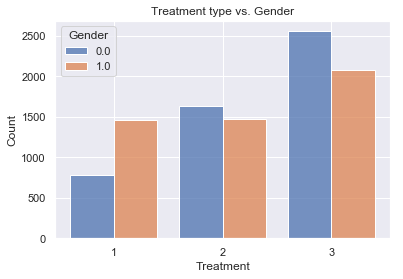

In [31]:
sns.set_theme()
sns.histplot(data = features.sort_values(by="Treatment"), x = "Treatment", hue = "Gender", multiple="dodge", shrink=.8)
plt.title("Treatment type vs. Gender")
plt.show()

We observe that there are more men who received Treatment 3 than woman, and there are more women who received Treatment 1 than men. The different treatments are not equally distributed amongst genders. If we have a policy that is unfair to one of the genders, then the policy might have decided to give the worse treatment to individuals of the gender that we treat unfairly, i.e giving women the less effective treatment. If our policy is fair, then the treatments are given to each genders truly based on what is the best for them. 

## Income

We categorize the individuals by their income. We now have two income categories: low and high income. Every individual with an income less than the median income for the entire population are categorized as `Low income`, and every individual with an income greater than the median income is categorized as `High income`. We would like to see which treatment is frequently given to individuals with low and high income.

In [32]:
# Income
median = features.Income.median()
features.loc[features.Income.values < median, "Income category"] = "Low income"
features.loc[features.Income.values >= median, "Income category"] = "High income"

i1 = features.groupby(by="Income category")["Treatment1"].value_counts(normalize=True)
i2 = features.groupby(by="Income category")["Treatment2"].value_counts(normalize=True)
i3 = features.groupby(by="Income category")["Treatment3"].value_counts(normalize=True)

In [33]:
i1, i2, i3 # Vet ikke om det er nødvendig

(Income category  Treatment1
 High income      0.0           0.8464
                  1.0           0.1536
 Low income       0.0           0.7028
                  1.0           0.2972
 Name: Treatment1, dtype: float64, Income category  Treatment2
 High income      0.0           0.6886
                  1.0           0.3114
 Low income       0.0           0.6890
                  1.0           0.3110
 Name: Treatment2, dtype: float64, Income category  Treatment3
 High income      1.0           0.5350
                  0.0           0.4650
 Low income       0.0           0.6082
                  1.0           0.3918
 Name: Treatment3, dtype: float64)

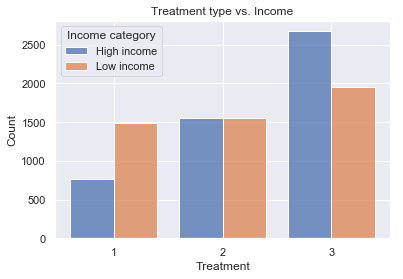

In [34]:
#sns.set_theme()
sns.histplot(data = features.sort_values(by="Treatment"), x = "Treatment", hue = "Income category", multiple="dodge", shrink=.8)
plt.title("Treatment type vs. Income")
plt.show()

While the Treatment 2 is given to same amount of individuals with low and high income, we also observe that the number of people with low income who received Treatment 3 is greater than the number of people with high income who receive the same treatment. We also see that many people with high income has received Treatment 1. The different treatments are not distributed evenly amongst the two groups.

## Age

We categorize the individuals by their age. We first tried to create five uniformly spaced age categories. However, this did not work very well, since the column `Age` has Gamma distribution and we have more young people than old people.

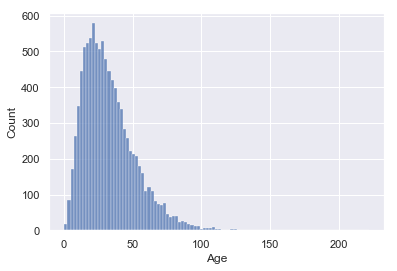

In [35]:
# Plot showing the age frequencies
sns.histplot(data = features, x = "Age")
plt.show()

In [36]:
age_limits = np.linspace(features.Age.min(), features.Age.max(), 6, dtype=int)
age_category = pd.DataFrame(pd.cut(features.Age, bins=age_limits,
                                   labels=["Age<24","24<=Age<47", "47<=Age<71", "71<=Age<94", "Age>94"],
                                   include_lowest=True, ordered=True))

age_category.columns = ["age_category"]
features = features.join(age_category)

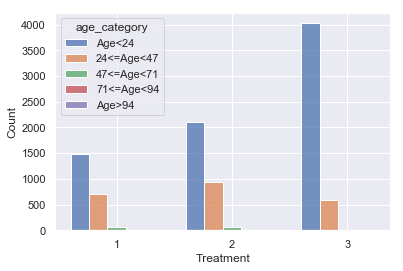

In [37]:
# Plot showing the age frequencies with 5 age categories
sns.histplot(data = features.sort_values(by="Treatment"), x = "Treatment", hue = "age_category", multiple="dodge", shrink=0.8)
plt.show()

We then decided to have two age categories: young and old. Every individual with an age smaller than the median age for the entire population are categorized as `Young`, and every individual with an age bigger than the median age is categorized as `Old`. We would like to see which treatment is frequently given to young and old individuals.

In [38]:
features.drop("age_category", axis=1, inplace=True)
median_age = features.Age.median()
features.loc[features.Age.values < median_age, "age_category"] = "Young"
features.loc[features.Age.values >= median_age, "age_category"] = "Old"

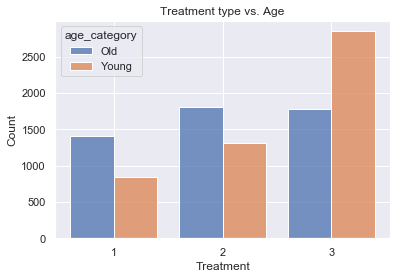

In [39]:
sns.histplot(data = features.sort_values(by="Treatment"), x = "Treatment", hue = "age_category", multiple="dodge", shrink=0.8)
plt.title("Treatment type vs. Age")
plt.show()

We observe that if the individual is young, they are often treated with Treatment 3. If the policy gives Treatment 3 to younger individuals simply because it is a better treatment method and we prioritize healing the young, then this is very unfair to the older individuals. However, if Treatment 3 is known to work better for young people and the other treatments work better for older people, then the policy is considered quite fair.

## Note: 

We have not yet quantified the fairness and balanced our policy. Our plan is to use the equality score from Dirk's 9th lecture, and then do a simple grid search on the balancing. Is it alright to use this simple way of balancing, instead of using neural networks and gradiant decent?